In [31]:
import pandas as pd
import numpy as np

from sklearn.tree import export_text

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, accuracy_score, f1_score

### Load saved splits and target variables

In [3]:
# Load data splits
df_full_train = pd.read_parquet("../data/interim/df_full_train.parquet")
df_train = pd.read_parquet("../data/interim/df_train.parquet")
df_val = pd.read_parquet("../data/interim/df_val.parquet")
df_test = pd.read_parquet("../data/interim/df_test.parquet")

# Load target variables
y_train = np.load("../data/interim/y_train.npy")
y_val = np.load("../data/interim/y_val.npy")
y_test = np.load("../data/interim/y_test.npy")

In [4]:
numerical = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
    'total_previous_visits',
    'had_previous_inpatient',
    'avg_medications_per_day',
    'procedure_to_lab_ratio',
    'num_medications_used',
    'num_adjusted_medications',
    'any_medication_change',
    'on_insulin'
]

In [5]:
categorical = ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

# Feature Importance: 
- Readmission Rate
- Risk ratio
- Mutual information
- Correlation


### Readmission Rate
#### Best for Binary variables
Questions:
- How does the mean rate tell us the important features?
- Should we do it on all features

In [6]:
global_readmitted = df_full_train.readmitted.mean()
global_readmitted

np.float64(0.11261239129366678)

In [7]:
readmitted_female = df_full_train[df_full_train.gender == 'female'].readmitted.mean()
readmitted_female

np.float64(0.11311752351383435)

In [8]:
readmitted_male = df_full_train[df_full_train.gender == 'male'].readmitted.mean()
readmitted_male

np.float64(0.11203297433851882)

In [9]:
global_readmitted - readmitted_female

np.float64(-0.0005051322201675701)

In [10]:
global_readmitted - readmitted_male

np.float64(0.00057941695514796)

### Risk Ratio
### Best for Categorical groups
Question: 
- what does the risk and diff tell us about these features

In [11]:
readmitted_female / global_readmitted

np.float64(1.0044855829306591)

In [12]:
readmitted_male / global_readmitted

np.float64(0.9948547673262974)

### Mutual information
### Best for Categorical groups
How much info a feature gives about target
- ✅ MI close to 0 → no info
- ✅ Higher MI → strong informative feature

In [13]:
from sklearn.metrics import mutual_info_score

In [14]:
def mutual_info_readmitted_score(series):
    return mutual_info_score(series, df_full_train.readmitted)

In [16]:
mi = df_full_train[categorical].apply(mutual_info_readmitted_score)
mi.sort_values(ascending=False)

diag_1                      8.969244e-03
diag_3                      8.143188e-03
diag_2                      7.503651e-03
insulin                     9.084641e-04
age                         5.814475e-04
diabetesMed                 4.114289e-04
metformin                   2.986104e-04
change                      1.700384e-04
race                        1.198009e-04
glipizide                   5.710555e-05
acarbose                    5.256147e-05
pioglitazone                4.801782e-05
repaglinide                 4.431814e-05
rosiglitazone               3.187767e-05
chlorpropamide              3.154034e-05
miglitol                    2.537009e-05
glyburide                   1.840014e-05
glimepiride                 1.602352e-05
glyburide-metformin         1.571878e-05
nateglinide                 1.537855e-05
gender                      5.865645e-06
tolbutamide                 4.334145e-06
metformin-rosiglitazone     2.935070e-06
troglitazone                2.935070e-06
tolazamide      

### Correlation
### Best for numerical features
- ➡️ High positive correlation → increases chance of readmission
- ➡️ High negative correlation → decreases it

In [17]:
df_full_train[numerical].corrwith(df_full_train.readmitted).abs()

time_in_hospital            0.044728
num_lab_procedures          0.019398
num_procedures              0.012659
num_medications             0.037057
number_outpatient           0.016453
number_emergency            0.059897
number_inpatient            0.166797
number_diagnoses            0.048522
total_previous_visits       0.125202
had_previous_inpatient      0.121765
avg_medications_per_day     0.014691
procedure_to_lab_ratio      0.017287
num_medications_used        0.004029
num_adjusted_medications    0.035507
any_medication_change       0.037265
on_insulin                  0.033934
dtype: float64

# One-hot encoding

In [18]:
dv = DictVectorizer(sparse=False)

In [19]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Training Logistic Regression

In [30]:
model = LogisticRegression(solver='lbfgs', max_iter=100)

model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [21]:
y_pred = model.predict_proba(X_val)[:, 1]

In [22]:
readmitted_decision = (y_pred >= 0.5)

In [24]:
# Coefficients
# Positive coefficient (+) ⇒ increases the chance of being readmitted

# Negative coefficient (−) ⇒ decreases the chance of readmission

feature_names = dv.get_feature_names_out()
coefs = model.coef_[0]
importance = sorted(zip(feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)
importance[:10]

[('had_previous_inpatient', np.float64(0.37709990435956364)),
 ('diag_1=434', np.float64(0.2381628137111889)),
 ('diabetesMed=no', np.float64(-0.2310077841439032)),
 ('glipizide=no', np.float64(-0.18243645780538198)),
 ('diag_1=486', np.float64(-0.17614112164267035)),
 ('diag_1=786', np.float64(-0.1706931990750227)),
 ('diag_2=250', np.float64(-0.17062648469144623)),
 ('diag_3=401', np.float64(-0.16415435230915246)),
 ('nateglinide=no', np.float64(-0.15308365805510366)),
 ('diag_3=585', np.float64(0.14263590578569246))]

## Evaluation of Logistic Regression

### Confusion Matrix

In [25]:

cm = confusion_matrix(y_val, readmitted_decision)
cm


array([[18044,    18],
       [ 2267,    24]])

### Accuracy, Precision, Recall, AUC, F1 Scores

In [35]:
readmitted_decision = (y_pred >= 0.5)

accuracy = accuracy_score(y_val, readmitted_decision)

precision = precision_score(y_val, readmitted_decision)

recall = recall_score(y_val, readmitted_decision)

f1 = f1_score(y_val, readmitted_decision)

auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy: {accuracy: .3f}")
print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")
print(f"AUC: {auc: .3f}")
print(f"F1: {f1: .3f}")

Accuracy:  0.888
Precision:  0.571
Recall:  0.010
AUC:  0.633
F1:  0.021


The logistic regression model achieves high accuracy (0.888), but this is misleading due to the severe class imbalance in the dataset. 

The model has moderate precision (0.571) but extremely low recall (0.010), indicating that it rarely identifies patients who will 
be readmitted. 

The F1 score is also low (0.021), reflecting this imbalance. However, the  AUC score of 0.633 suggests that the model does capture some predictive signal and performs better than random guessing. 

Overall, logistic regression struggles to detect readmissions  in this dataset, primarily due to imbalanced classes and noisy features.


# Model tunning

In [29]:

C_grid = [0.01, 0.1, 1, 10, 100]
scores = []

for C in C_grid:

    # Create the model instance
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    print(C)
    converted_decision = (y_pred >= 0.5)
    accuracy = (y_val == converted_decision).mean()
    
    precision = precision_score(y_val, readmitted_decision)
    
    recall = recall_score(y_val, readmitted_decision)

    auc = roc_auc_score(y_val, y_pred)
    scores.append({
        'C': C,
        'accuracy': round(accuracy, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'auc': round(auc, 3)
    })

print(scores)

0.01
0.1
1
10
100
[{'C': 0.01, 'accuracy': np.float64(0.888), 'precision': 0.571, 'recall': 0.01, 'auc': 0.633}, {'C': 0.1, 'accuracy': np.float64(0.888), 'precision': 0.571, 'recall': 0.01, 'auc': 0.633}, {'C': 1, 'accuracy': np.float64(0.888), 'precision': 0.571, 'recall': 0.01, 'auc': 0.633}, {'C': 10, 'accuracy': np.float64(0.888), 'precision': 0.571, 'recall': 0.01, 'auc': 0.633}, {'C': 100, 'accuracy': np.float64(0.888), 'precision': 0.571, 'recall': 0.01, 'auc': 0.633}]


# Evaluate the model on different thresholds

In [39]:
thresholds = np.linspace(0, 1, 21)

results = []

for t in thresholds:
    preds = (y_pred >= t)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    results.append((t, precision, recall, f1))

df_thr = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1'])
df_thr.head()


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/li

,threshold,precision,recall,f1
0,0.00,0.112563,1.000000,0.202349
1,0.05,0.114489,0.981231,0.205053
2,0.10,0.151684,0.605412,0.242589
3,0.15,0.199609,0.356176,0.255839
4,0.20,0.254613,0.180707,0.211386


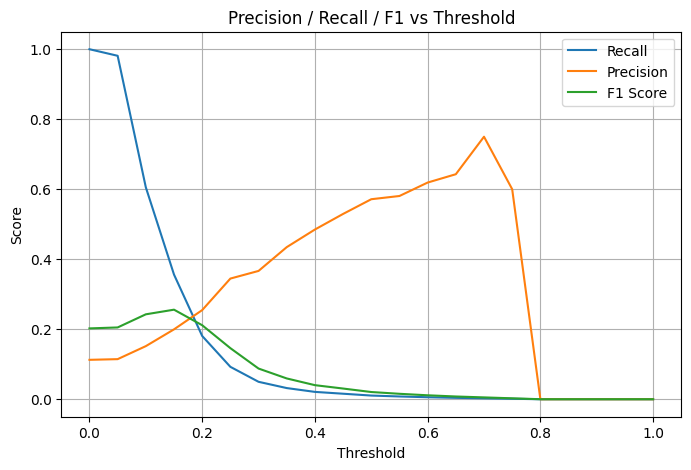

In [40]:
plt.figure(figsize=(8,5))
plt.plot(df_thr.threshold, df_thr.recall, label="Recall")
plt.plot(df_thr.threshold, df_thr.precision, label="Precision")
plt.plot(df_thr.threshold, df_thr.f1, label="F1 Score")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.grid(True)
plt.legend()
plt.show()


In [41]:
best_row = df_thr.loc[df_thr.f1.idxmax()]
best_row


threshold    0.150000
precision    0.199609
recall       0.356176
f1           0.255839
Name: 3, dtype: float64

Lower thresholds increase recall

Higher thresholds increase precision

F1 finds the best balance